## 基本⽬標

### Target 1
透過開發者⼯具觀察網站在列出 News Feed 這邊是屬於動態網站還是靜態網站，或是有 API 可以直接送 requests

- Ans: NewsFeed 屬於動態網站，當向下滾動時會透過非同步的方式載入檔案，包含三個檔案，如下圖
    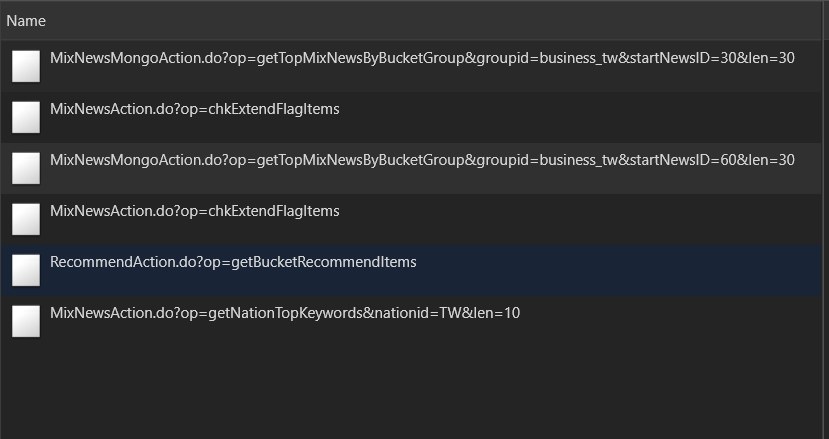
    
    若想要植基透過API取得新聞內容，可以透過
    
    "https://www.cupoy.com/MixNewsMongoAction.do?op=getTopMixNewsByBucketGroup&groupid=business_tw&startNewsID=0&len=2"
    
    的方式提出請求，其中參數"groupid"表示新聞種類、"startNewsID"表示從第幾則新聞開始顯示、"len"表示顯示新聞則數
        

### Target 2
根據網站特性選擇 requests / BeautifulSoup / selenium 等⼯具進⾏爬蟲整理

In [12]:
# 將需要的套件引入
import requests
import pandas as pd
import json
import jieba
import sys
import matplotlib.pyplot as plt
import numpy as np
import jieba.analyse

from collections import Counter
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

In [13]:
# 使用網頁結合 selenium 的方式爬取速度慢，標籤定位麻煩
# 經過確認後，可以直接向 Cupoy 網頁使用的 API 發送請求，並且可以直接設定要拿取的文章數量
# 在各項參數中，groupid 表示文章種類、startNewsID 表示從編號多少的文章開始送請求、len 表示請求的文章數量
# 本專題以「商業」文章為例
Cupoy_api = "https://www.cupoy.com/MixNewsMongoAction.do?" \
"op=getTopMixNewsByBucketGroup&groupid=business_tw&startNewsID=0&len=500"

In [14]:
# 使用 requests 發送請求
res = requests.get(Cupoy_api)

# 若回傳狀態碼為 200 以外視為錯誤，跳出錯誤訊息後結束程式
try:
    if res.status_code != 200:
        sys.exit(0)
except:
    print('Request Error!!')
    
# 收到回應後印出前 2000 個字元確認內容
print(res.text[:2000])

{"items":[{"itemuid":"68747470733A2F2F65646D2E6D616E61676572746F6461792E636F6D2E74772F6E65676F74696174696F6E2F73756E747A752F3F75746D5F736F757263653D66616365626F6F6B5F6D742675746D5F6D656469756D3D6164706F73742675746D5F63616D706169676E3D32303230713273756E747A75","newsid":"00000171A5F24BE068747470733A2F2F65646D2E6D616E61676572746F6461792E636F6D2E74772F6E65676F74696174696F6E2F73756E747A752F3F75746D5F736F757263653D66616365626F6F6B5F6D742675746D5F6D656469756D3D6164706F73742675746D5F63616D706169676E3D32303230713273756E747A75","itemsrctype":2,"ctype":5,"title":"職場必修談判課！劉必榮講座｜向孫子兵法學商業談判｜經理人商學院課程","description":"比爾蓋茲、大前研一等成功經理人都愛讀的《孫子兵法》，如何助你活用致勝？談判權威劉必榮，教你轉譯經典兵法的談判技巧，圖像化帶你從情境學談判謀略與戰術，精準說服、翻倍業績！","thumbimgurl":"https://edm.managertoday.com.tw/negotiation/suntzu/assets/images/fbshare.jpg","linkurl":"https://edm.managertoday.com.tw/negotiation/suntzu/?utm_source\u003dfacebook_mt\u0026utm_medium\u003dadpost\u0026utm_campaign\u003d2020q2suntzu","nationID":"TW","publishtime":1587627052000,"bucketids":

In [15]:
# 將收到的字串主換成 json格式檔案，以便篩選
data = json.loads(res.text)

data_list = []

# 確認文章標題、簡述、連結是否在每一則文章後將其取出
for item in data["items"]:
    title = item['title']
    
    if 'description' in item.keys() :
        description = item['description']
    else:
        description = ''
    
    if 'linkurl' in item.keys() :
        linkurl = item['linkurl']
    else:
        linkurl = ''
        
    # 將資料整理至一串列中  
    data_list.append([title, description, linkurl])

data_list[:5]

[['職場必修談判課！劉必榮講座｜向孫子兵法學商業談判｜經理人商學院課程',
  '比爾蓋茲、大前研一等成功經理人都愛讀的《孫子兵法》，如何助你活用致勝？談判權威劉必榮，教你轉譯經典兵法的談判技巧，圖像化帶你從情境學談判謀略與戰術，精準說服、翻倍業績！',
  'https://edm.managertoday.com.tw/negotiation/suntzu/?utm_source=facebook_mt&utm_medium=adpost&utm_campaign=2020q2suntzu'],
 ['比利時研究團隊新發現：不上網，駭客利用電腦風扇也能竊取資料 | TechNews 科技新報',
  '對於駭客來說，沒有他們做不到，只有你想不到的事。近日，以色列的一個研究團隊發現，可以利用一種特別的方式，「不動聲色」地從電腦中竊取數據。\r\n\r\n以色列本‧古裏安大學的研究團隊發現了竊取電腦數據的一種新方式──Air-ViBeR。他們已經不是第一次研究出這種奇特的技術來獲取電腦數據，比如之前的利用硬碟...',
  'https://technews.tw/2020/04/23/academics-steal-data-from-air-gapped-systems-using-pc-fan-vibrations/?utm_source=fb_tn&utm_medium=facebook'],
 ['【時力專欄】推動臺灣塑膠包裝的轉型！王婉諭：請環保署簽署《新塑膠經濟全球承諾》 | BuzzOrange',
  '【我們為什麼要挑選這篇文章】 環保議題日漸備受重視，各國除了積極減碳，也對塑膠頒布相關禁令，盼能降低塑膠的使用量。不外乎是因為塑膠從生產、使用到丟棄，各個階段都會對地球產生傷害。 據《中央社》報導，環[...]',
  'https://buzzorange.com/2020/04/23/we-need-to-sign-new-plastics-economy-global-commitment/'],
 ['【美國獨立建國 244 年來第一次】川普簽署禁令，60 天內不再接受移民進入美國 | BuzzOrange',
  '根據《中央社》快訊，美國總統川普在美東時間 4 月 22 日 宣佈 ，已簽署命令，暫禁移民入境美國，稱目的是要在疫情氾濫時

### Target 3
整理成 pandas.DataFrame 後做簡單的統計可以⽤ matplotlib.pyplot 或是pandas 內建的 function 畫圖 (histogram / pie chart ...)

In [16]:
# 將取得的文章標題、文章簡述、文章連結轉換成 pandas dataframe
df = pd.DataFrame(data_list, columns=['title', 'description', 'linkurl'])
df.head(5)

,title,description,linkurl
0,職場必修談判課！劉必榮講座｜向孫子兵法學商業談判｜經理人商學院課程,比爾蓋茲、大前研一等成功經理人都愛讀的《孫子兵法》，如何助你活用致勝？談判權威劉必榮，教你轉...,https://edm.managertoday.com.tw/negotiation/su...
1,比利時研究團隊新發現：不上網，駭客利用電腦風扇也能竊取資料 | TechNews 科技新報,對於駭客來說，沒有他們做不到，只有你想不到的事。近日，以色列的一個研究團隊發現，可以利用一種...,https://technews.tw/2020/04/23/academics-steal...
2,【時力專欄】推動臺灣塑膠包裝的轉型！王婉諭：請環保署簽署《新塑膠經濟全球承諾》 | Buzz...,【我們為什麼要挑選這篇文章】 環保議題日漸備受重視，各國除了積極減碳，也對塑膠頒布相關禁令，...,https://buzzorange.com/2020/04/23/we-need-to-s...
3,【美國獨立建國 244 年來第一次】川普簽署禁令，60 天內不再接受移民進入美國 | Buz...,根據《中央社》快訊，美國總統川普在美東時間 4 月 22 日 宣佈 ，已簽署命令，暫禁移民入...,https://buzzorange.com/2020/04/23/king-trump/
4,究竟是他國「佛系防疫」還是我們不懂差異？談「臺灣成功」為何難以複製 ｜ 賴姿蓉／讀者投書 ｜...,臺灣的防疫實力與卓越表現已成為世界話題，外媒體相爭報導。而在臺灣驕傲的同時，新聞媒體與名嘴們...,https://crossing.cw.com.tw/article/13289?utm_s...


In [17]:
# 以較常出現的幾個網站作為統計內容
# 以 The News Lens 關鍵評論網、風傳媒、數位時代、Anue鉅亨網、商周財富網、INSIDE、T客邦、經理人為統計目標
# 其他次數較少的網站歸類在「其他」分類當中

# 首先建立 keys
count_dict = {
    "關鍵評論網": 0,
    "風傳媒": 0,
    "數位時代": 0,
    "Anue鉅亨": 0,
    "商周財富網": 0,
    "INSIDE": 0,
    "經理人": 0,
    "T客邦": 0,
    "其他": 0
}

# 計算各目標網站文章出現次數
for title in df['title']:
    if "關鍵評論網" in title:
        count_dict["關鍵評論網"] += 1
    if "風傳媒" in title:
        count_dict["風傳媒"] += 1
    if "數位時代" in title:
        count_dict["數位時代"] += 1
    if "Anue鉅亨" in title:
        count_dict["Anue鉅亨"] += 1
    if "商周財富網" in title:
        count_dict["商周財富網"] += 1
    if "INSIDE" in title:
        count_dict["INSIDE"] += 1
    if "經理人" in title:
        count_dict["經理人"] += 1
    if "T客邦" in title:
        count_dict["T客邦"] += 1

count_dict["其他"] = 500 - count_dict["關鍵評論網"] - count_dict["風傳媒"] - count_dict["數位時代"] - count_dict["Anue鉅亨"] - \
                    count_dict["商周財富網"] - count_dict["INSIDE"] - count_dict["經理人"] - count_dict["T客邦"]

print(count_dict)

{'關鍵評論網': 78, '風傳媒': 71, '數位時代': 37, 'Anue鉅亨': 32, '商周財富網': 31, 'INSIDE': 17, '經理人': 14, 'T客邦': 15, '其他': 205}


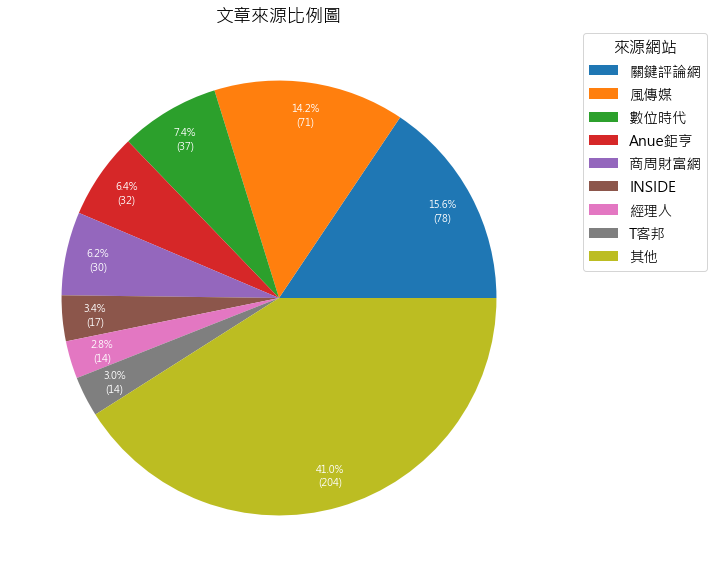

In [18]:
# 指定使用字體，使 matplotlib 能夠顯示中文字
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 使用 matpllotlib 進行繪圖
# 設定輸出圖形大小
plt.figure(figsize=(10,10))

# 用於繪圖的資料格式必須是串列，所以先將字典格式資料轉成串列型態
data = list(count_dict.values())
keys = count_dict.keys()

# 函數用來定義放在圓餅圖上的顯示格式
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# 繪製圓餅圖
plt.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="w"), pctdistance=0.85)

# 設定圖示
graph = plt.legend(keys, title="網站來源", bbox_to_anchor=(1, 0, 0.3, 1), fontsize="x-large")
graph.set_title('來源網站',prop={'size':16})

# 設定圖形標題
plt.title("文章來源比例圖", size=18)

plt.show()

## 進階目標

## Target 1
爬下⽂章，透過 jieba 等斷詞將⽂章拆解
## Target 2
可以簡單的計算同樣⽂字出現的頻率或是透過 TFIDF 的統計⽅式計算
## Target 3
將經常出現的 stop words 過濾掉之後對頻率進⾏排名

In [19]:
# 將所有文章標題串列中的文字串接以進行 jieba 斷詞
total = ''.join(df["title"])

# 將斷詞詞庫切換到 dic.txt.big，使繁體中文的斷詞表現較佳
jieba.set_dictionary('dict.txt.big.txt')

# 設定 jieba 使用者自訂字典，以各類網路文章網站為主要目標
# 參考 userdict.txt 檔案
jieba.load_userdict(r'userdict.txt')
 
# 自訂連接詞、轉折用語等冗餘字詞
# 參考 stopWord.txt 檔案
with open(r'stopWord.txt', 'r', encoding='utf8') as f:  
    stops = f.read().split('\n')

# 進行斷詞後，先將冗餘字詞排除，接著依照詞頻進行降冪排序
terms = []
for term in jieba.cut(total, cut_all=True):
    if term not in stops:
        terms.append(term)

word_times = sorted(Counter(terms).items(), key=lambda x:x[1], reverse=True)

print([word for word in word_times if len(word[0]) >= 3 and word[1]>10 ])

[('關鍵評論網', 78), ('風傳媒', 71), ('數位時代', 37), ('財富網', 33), ('Anue鉅亨', 32), ('商周財富網', 31), ('INSIDE', 16), ('T客邦', 15), ('經理人', 14), ('2020', 12), ('Google', 11)]


In [20]:
# 簡單使用 TFIDF 計算權重最高的前 20 個詞彙
jieba.analyse.extract_tags(total, topK=20, withWeight=False, allowPOS=())

['News',
 'Lens',
 '關鍵評論網',
 '風傳媒',
 '數位時代',
 'Anue鉅亨',
 '疫情',
 '商周財富網',
 '理財',
 '中國',
 '什麼',
 '美國',
 '員工',
 '經濟',
 '油價',
 '財經',
 '紓困',
 '防疫',
 '肺炎',
 '新冠']

## Target 4
將結果透過 wordcloud ⽂字雲的⽅式呈現

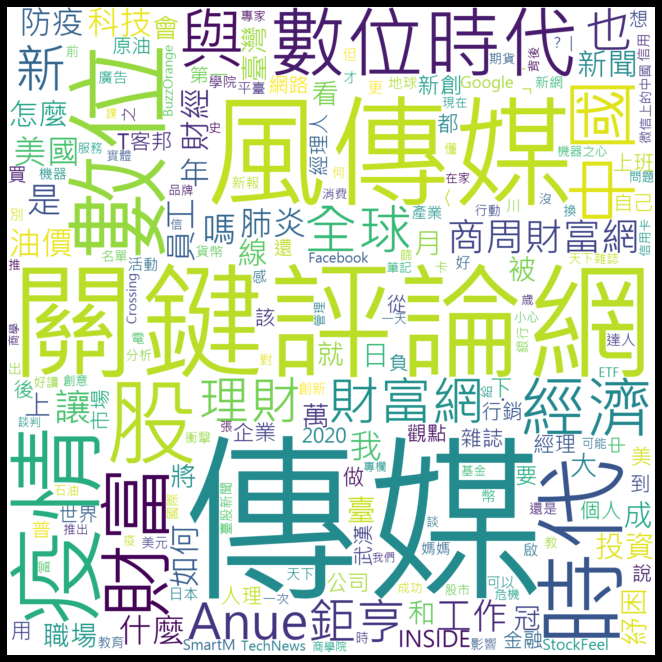

In [21]:
# 使用微軟正黑體顯示文字雲
# background_color 用來設定背景顏色，預設為黑色，改為白色
# font_path 用來指定自型，以微軟正黑體為例
wordcloud = WordCloud(background_color="white", font_path=r'msjh.ttc', collocations=False, width=1800, height=1800)
# 依照詞彙頻率繪製文字雲
wordcloud.generate_from_frequencies(frequencies=Counter(terms))
 
# 產生圖片
plt.figure(figsize=(12,9), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

# 另存圖檔
# plt.savefig("Wordcloud.png")